In [1]:
pip install biobert-embedding==0.1.2 torch==1.2.0 -f https://download.pytorch.org/whl/torch_stable.html 

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 663.1MB 25kB/s 
     |████████████████████████████████| 133kB 6.9MB/s 
     |████████████████████████████████| 133kB 34.1MB/s 
     |████████████████████████████████| 7.7MB 37.3MB/s 
     |████████████████████████████████| 81kB 8.1MB/s 
  Created wheel for biobert-embedding: filename=biobert_embedding-0.1.2-cp37-none-any.whl size=5701 sha256=60d0f18cdc83765ad2809a5abe78ae8f9251df941ea8078de1f5aac2ce1f3a97
  Stored in directory: /root/.cache/pip/wheels/ad/15/65/3fc6192a7cb7920672bb46d566173decb0875f35bbe03cd09d
Successfully built biobert-embedding
ERROR: torchvision 0.10.0+cu102 has requirement torch==1.9.0, but you'll have torch 1.2.0+cu92 which is incompatible.
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.2.0+cu92 which is incompatible.
ERROR: botocore 1.20.102 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incomp

In [2]:
from biobert_embedding.embedding import BiobertEmbedding 

In [3]:
biobert = BiobertEmbedding()

/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)
/usr/local/lib/python3.7/dist-packages/urllib3/connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is be

In [4]:
import numpy as np
import pandas as pd 

In [5]:
doc_vectors=pd.read_csv('/content/preprocessed_ade.csv') 

In [6]:
doc_vectors

,Unnamed: 0,observation,labels
0,12606,early phase ii semi double blind study of the ...,0
1,685,cessation of mtx therapy led to complete regre...,0
2,5127,cutaneous biopsy showed hyphae and round inclu...,0
3,3158,she was treated with acyclovir and subsequentl...,1
4,10685,cisplatin was substituted and the patient achi...,0
...,...,...,...
23511,982,ticlopidine induced aplastic anemia two new c...,1
23512,14487,the risks of sumatriptan administration in pat...,0
23513,4680,however the spectrum of hosts and clinical p...,0
23514,2588,antibiotic treatment should be continued,0


In [7]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences 

In [8]:
#doc_vectors = pd.read_csv('/content/biobert_embeddings.csv') 

In [9]:
doc_vectors.drop(columns='Unnamed: 0' , inplace= True)

In [10]:
req_lines = list()
lines = doc_vectors["observation"].values.tolist()

In [11]:
lines[0]

'early phase ii semi double blind study of the new alkaline propanolamine derivative enciprazine   short communication'

In [12]:
import nltk 
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [13]:
from nltk import word_tokenize 
from nltk.corpus import stopwords


In [14]:
import string

In [15]:
#stopwords = set(nltk.corpus.stopwords.words('english'))

In [17]:
max_feature_length = 768
tokenizer = Tokenizer(num_words=max_feature_length, split=' ')
tokenizer.fit_on_texts(doc_vectors['observation'].values)
x = tokenizer.texts_to_sequences(doc_vectors['observation'].values)
x = pad_sequences(x,maxlen=max_feature_length)
word_index = tokenizer.word_index 

In [18]:
len(word_index)

16445

In [19]:
y = doc_vectors['labels'].values

In [20]:
print(x.shape)
print(y.shape)

(23516, 768)
(23516,)


**SMOTE**

In [21]:
from imblearn.over_sampling import SMOTE 

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2021)

In [25]:
smote = SMOTE(random_state = 2021)
x_train, y_train = smote.fit_resample(x_train,y_train) 

In [27]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(26670, 768)
(26670,)
(4704, 768)
(4704,)


In [28]:
embedding_dim = 768
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    #if word in word2vec_model: 
        embedding_vector = biobert.sentence_vector(word)
        embedding_matrix[i] = embedding_vector 

In [29]:
from keras.layers import Embedding

In [30]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            trainable=False) 

In [31]:
import tensorflow as tf 

In [32]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM
from keras.layers.embeddings import Embedding
from keras.initializers import Constant
from keras.callbacks import ModelCheckpoint
from keras.models import load_model 

In [33]:
print(x_train.shape , y_train.shape)
print(x_test.shape, y_test.shape)

(26670, 768) (26670,)
(4704, 768) (4704,)


In [34]:
model_biobert = Sequential()
model_biobert.add(embedding_layer) 
model_biobert.add(LSTM(192))

model_biobert.add(Dense(1, activation='sigmoid'))


model_biobert.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
history=model_biobert.fit(x_train,y_train, batch_size=500, epochs=10, validation_data=(x_test, y_test),shuffle=True) 


Epoch 1/10
54/54 [==============================] - 1551s 28s/step - loss: 0.7630 - accuracy: 0.5238 - val_loss: 0.6466 - val_accuracy: 0.7009
Epoch 2/10
54/54 [==============================] - 1480s 27s/step - loss: 0.6423 - accuracy: 0.6494 - val_loss: 0.6331 - val_accuracy: 0.6494
Epoch 3/10
54/54 [==============================] - 1460s 27s/step - loss: 0.5880 - accuracy: 0.6857 - val_loss: 0.5588 - val_accuracy: 0.7266
Epoch 4/10
54/54 [==============================] - 1481s 27s/step - loss: 0.5368 - accuracy: 0.7288 - val_loss: 0.5253 - val_accuracy: 0.7426
Epoch 5/10
54/54 [==============================] - 1465s 27s/step - loss: 0.5013 - accuracy: 0.7508 - val_loss: 0.4939 - val_accuracy: 0.7736
Epoch 6/10
54/54 [==============================] - 1464s 27s/step - loss: 0.4676 - accuracy: 0.7741 - val_loss: 0.4653 - val_accuracy: 0.7919
Epoch 7/10
54/54 [==============================] - 1462s 27s/step - loss: 0.4540 - accuracy: 0.7862 - val_loss: 0.4413 - val_accuracy: 0.7953

In [36]:
import matplotlib.pyplot as plt 

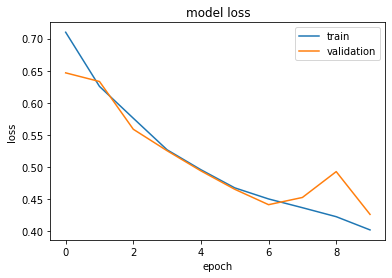

In [37]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show() 

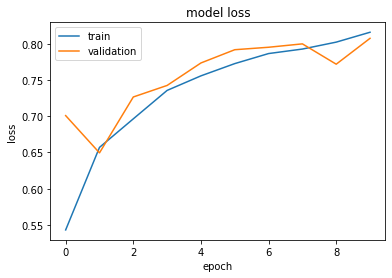

In [42]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.show() 

In [38]:
y_pred = model_biobert.predict_classes(x_test)

/usr/local/lib/python3.7/dist-packages/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [39]:
from sklearn.metrics import confusion_matrix,classification_report

In [40]:
print(confusion_matrix(y_test,y_pred))

[[2959  401]
 [ 504  840]]


In [41]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.87      3360
           1       0.68      0.62      0.65      1344

    accuracy                           0.81      4704
   macro avg       0.77      0.75      0.76      4704
weighted avg       0.80      0.81      0.81      4704

